In [64]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image
from sklearn.metrics import root_mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [53]:
df = pd.read_csv("../DATA/aus_livestock.csv")
df["ds"] = pd.to_datetime(df.ds)
df = df[df.unique_id == "New South Wales_Pigs"]
df = df.set_index("ds")
train = df[df.index.year <= 2012]
test = df[df.index.year > 2012]
train.head()

,unique_id,y
ds,,
1972-07-01,New South Wales_Pigs,97400.0
1972-08-01,New South Wales_Pigs,114700.0
1972-09-01,New South Wales_Pigs,109900.0
1972-10-01,New South Wales_Pigs,108300.0
1972-11-01,New South Wales_Pigs,122200.0


In [30]:
stl = STL(train.y, period=12).fit()

stl.plot()

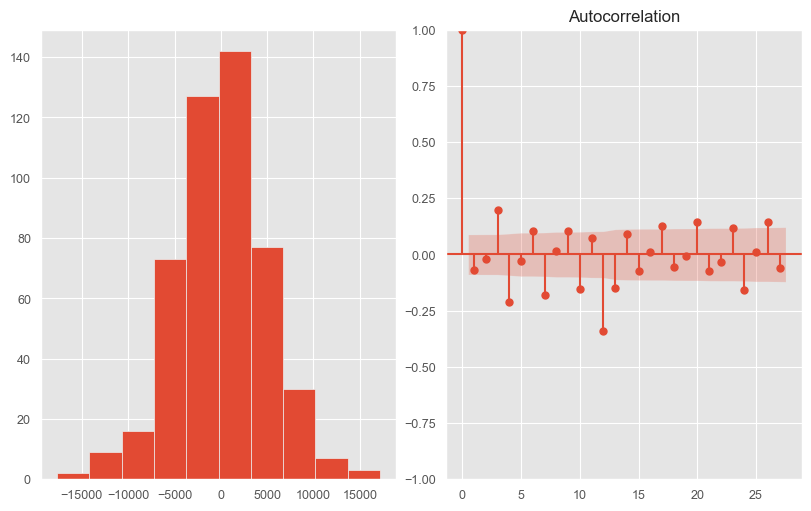

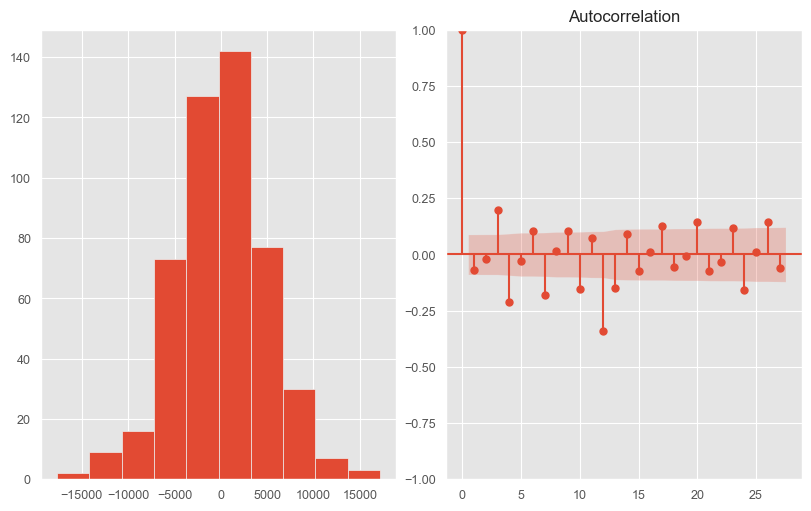

In [38]:
fig, axes = plt.subplots(1, 2)

stl.resid.hist(ax=axes[0])
plot_acf(stl.resid, ax=axes[1])

In [75]:
methods = [
    SeasonalNaive(season_length=12),
    HistoricAverage(),
    Naive(),
    RandomWalkWithDrift(),
    WindowAverage(12),
]

rmse_results = {}

for method in methods:
    method.fit(train.y)
    y_pred = method.predict(h=72)["mean"]
    rmse_results[method] = root_mean_squared_error(test.y, y_pred)

print(pd.Series(rmse_results).sort_values())

RWD                 8091.302
WindowAverage       8737.539
Naive               8940.754
SeasonalNaive      10111.428
HistoricAverage    39893.665
dtype: float64


In [82]:
model = RandomWalkWithDrift().fit(train.y)
resid = train.y - model.forecast(train.y, h=1, fitted=True)["fitted"]

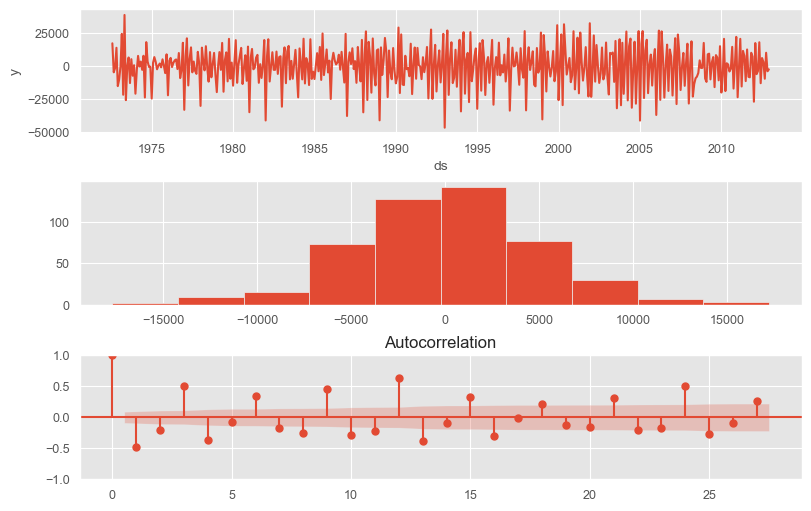

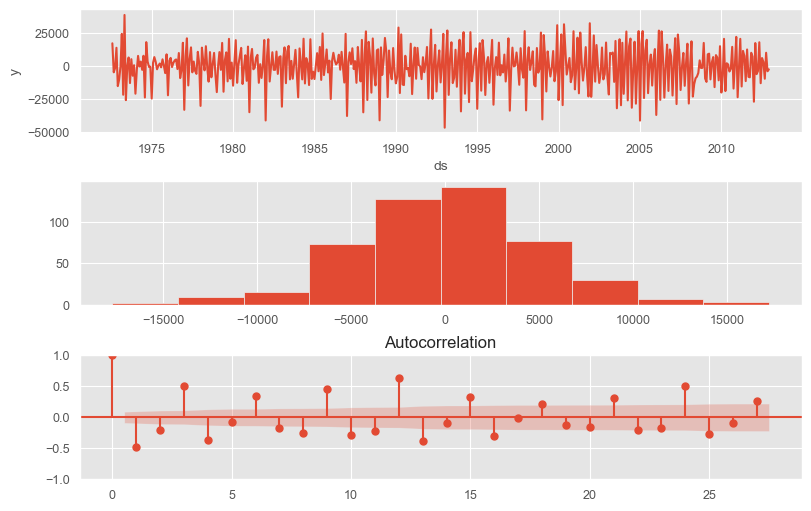

In [92]:
fig, axes = plt.subplots(3, 1)

sns.lineplot(resid, ax=axes[0])
stl.resid.hist(ax=axes[1])
plot_acf(resid.dropna(), ax=axes[2])

In [90]:
acorr_ljungbox(resid.dropna())

,lb_stat,lb_pvalue
1,114.704,9.135e-27
2,135.116,4.570e-30
3,259.021,7.322e-56
4,323.885,7.608e-69
5,327.229,1.394e-68
6,386.555,2.170e-80
7,401.999,8.890e-83
8,431.966,2.697e-88
9,537.976,4.209e-110
10,580.870,2.206e-118
